In [1]:
import json 
import os 
import cv2
from pprint import pprint
import requests
import numpy as np
import random
import math
import albumentations as A
from tqdm import tqdm
import uuid
import requests
from matplotlib import pyplot as plt
%matplotlib inline

/home/hbdesk/labelstudio_convert/venv/lib/python3.12/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
OCR_SERVER="http://localhost:3000/en"


def string_from_img(image_path: str):
    with open(image_path, "rb") as image_file:
        files = { "file": (image_path, image_file, "image/jpeg") }
        response = requests.post(OCR_SERVER, files=files)
        if response.status_code==200:
            res_string = response.json()["string"]
            return res_string
        else:
            return None

def get_file_by_extension(target_folder: str, extensions: tuple):
    '''
    Takes in a target folder and a tuple of extensions,
    returns a list of path strings of files with the specified extensions,
    including those in subfolders.
    '''
    _a = []
    for root, _, files in os.walk(target_folder):
        for file in files:
            if file.endswith(extensions):
                _a.append(os.path.join(root, file))
    return _a

In [3]:
all_jsons = get_file_by_extension("/home/hbdesk/labelstudio_convert/bbox_tall", ".json")

In [4]:
load_data = []
for anno in all_jsons:
    with open(anno, "r") as loadjson:
        data = json.loads(loadjson.read())
        load_data.append(data)

In [22]:
strings = []
stacked = []
for shit in tqdm(load_data):
    image = cv2.imread(shit["imagePath"])
    string_img = string_from_img(shit["imagePath"])
    string_img = string_img.replace(" ", "")
    strings.append(string_img)
    stack1 = []
    for annotation in shit["shapes"]:
        x1,y1 = [int(x) for x in annotation["points"][0]]
        x2,y2 = [int(x) for x in annotation["points"][1]]
        crop = image[y1:y2, x1:x2]
        h, w, c = crop.shape
        pad_width = max(0, 24 - w)
        pad_height = max(0, 24 - h)
        top = pad_height // 2
        bottom = pad_height - top
        left = pad_width // 2
        right = pad_width - left
        _pad = np.pad(crop, ((top, bottom), (left, right), (0, 0)), mode='constant', constant_values=0)
        _pad = cv2.cvtColor(_pad, cv2.COLOR_BGR2GRAY)
        stack1.append(_pad)
        # cv2.imwrite(f"chars2/{uuid.uuid4().hex}.png", _pad)      
    stacked.append(stack1)
        

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 990/990 [02:22<00:00,  6.96it/s]


R o f l a n _ n o n a m e


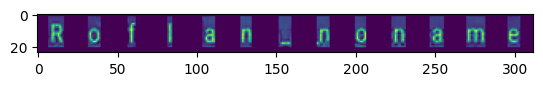

In [23]:
INDEX = 4
print(" ".join(strings[INDEX]))
plt.imshow(np.hstack(stacked[INDEX]))
plt.show()

In [24]:
_set_string = set(strings)
chars = sorted(set("".join(_set_string)))
dest = "/home/hbdesk/labelstudio_convert/chars2"
for char in chars:
    _dst = os.path.join(dest, char)
    if not os.path.exists(_dst):
        os.makedirs(_dst)

In [25]:
dest = "/home/hbdesk/labelstudio_convert/chars2"
for _stridx, _string in enumerate(strings):
    img_list = stacked[_stridx]
    for _charidx, _char in enumerate(_string):
        dest_save_path = os.path.join(dest, _char)
        save_fname = f"{dest_save_path}/{uuid.uuid4().hex}.png"
        try:
            cv2.imwrite(save_fname, img_list[_charidx])
        except:
            pass